In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lingua import Language, LanguageDetectorBuilder

In [2]:
src = "../eval_results/xlsum/run_lead_in_1_rescored_full_article/"

In [3]:
langs = [
    ("en", Language.ENGLISH),
    ("fr", Language.FRENCH),
    ("ru", Language.RUSSIAN),
    ("uk", Language.UKRAINIAN), 
    ("es", Language.SPANISH), 
    ("vi", Language.VIETNAMESE), 
    ("id", Language.INDONESIAN),
    ("zh", Language.CHINESE),
    ("hi", Language.HINDI),

]

languages = [Language.ENGLISH, 
             Language.FRENCH, 
             Language.SPANISH, 
             Language.UKRAINIAN, 
             Language.RUSSIAN, 
             Language.VIETNAMESE, 
             Language.INDONESIAN, 
             Language.CHINESE, 
             Language.HINDI]

detector = LanguageDetectorBuilder.from_languages(*languages).build()

def get_filter(l_code):
    def lang_filter(row):
        return detector.detect_language_of(str(row["response"])) == l_code
    return lang_filter

quants = [
    ("hf", "16"),
    ("hf", "4"),
    ("rtn", "4"),
    ("awq", "4"),
    ("gptq", "4"),
]

In [4]:
def prep_data_per_lang(metrics, method, precision, filter_out=False):
    merge = None
    for lang, l_code in langs:
        data = pd.read_csv(f"{src}/{lang}/{method}_{precision}.csv", index_col=0)
        
        if filter_out:
            data = data[data.apply(get_filter(l_code), axis=1)]
        data["Languages:"] = lang
        if merge is None:
            merge = data
        else:
            merge = pd.concat([merge, data])
    melted = pd.melt(merge, id_vars=["Languages:"], value_vars=metrics, var_name='')
    return melted

In [5]:
def prep_data_per_quant(lang_col_name, quant_col_name, filter_out=False):
    bigmerge = None
    for method, precision in quants:
        merge = None
        for lang, l_code in langs:
            data = pd.read_csv(f"{src}/{lang}/{method}_{precision}.csv", index_col=0)
            if filter_out:
                data = data[data.apply(get_filter(l_code), axis=1)]
            data[lang_col_name] = lang
            if merge is None:
                merge = data
            else:
                merge = pd.concat([merge, data])
        merge[quant_col_name] = f"{method} {precision}bit"
        if bigmerge is None:
            bigmerge = merge
        else:
            bigmerge = pd.concat([bigmerge, merge])
    return bigmerge

<Axes: ylabel='value'>

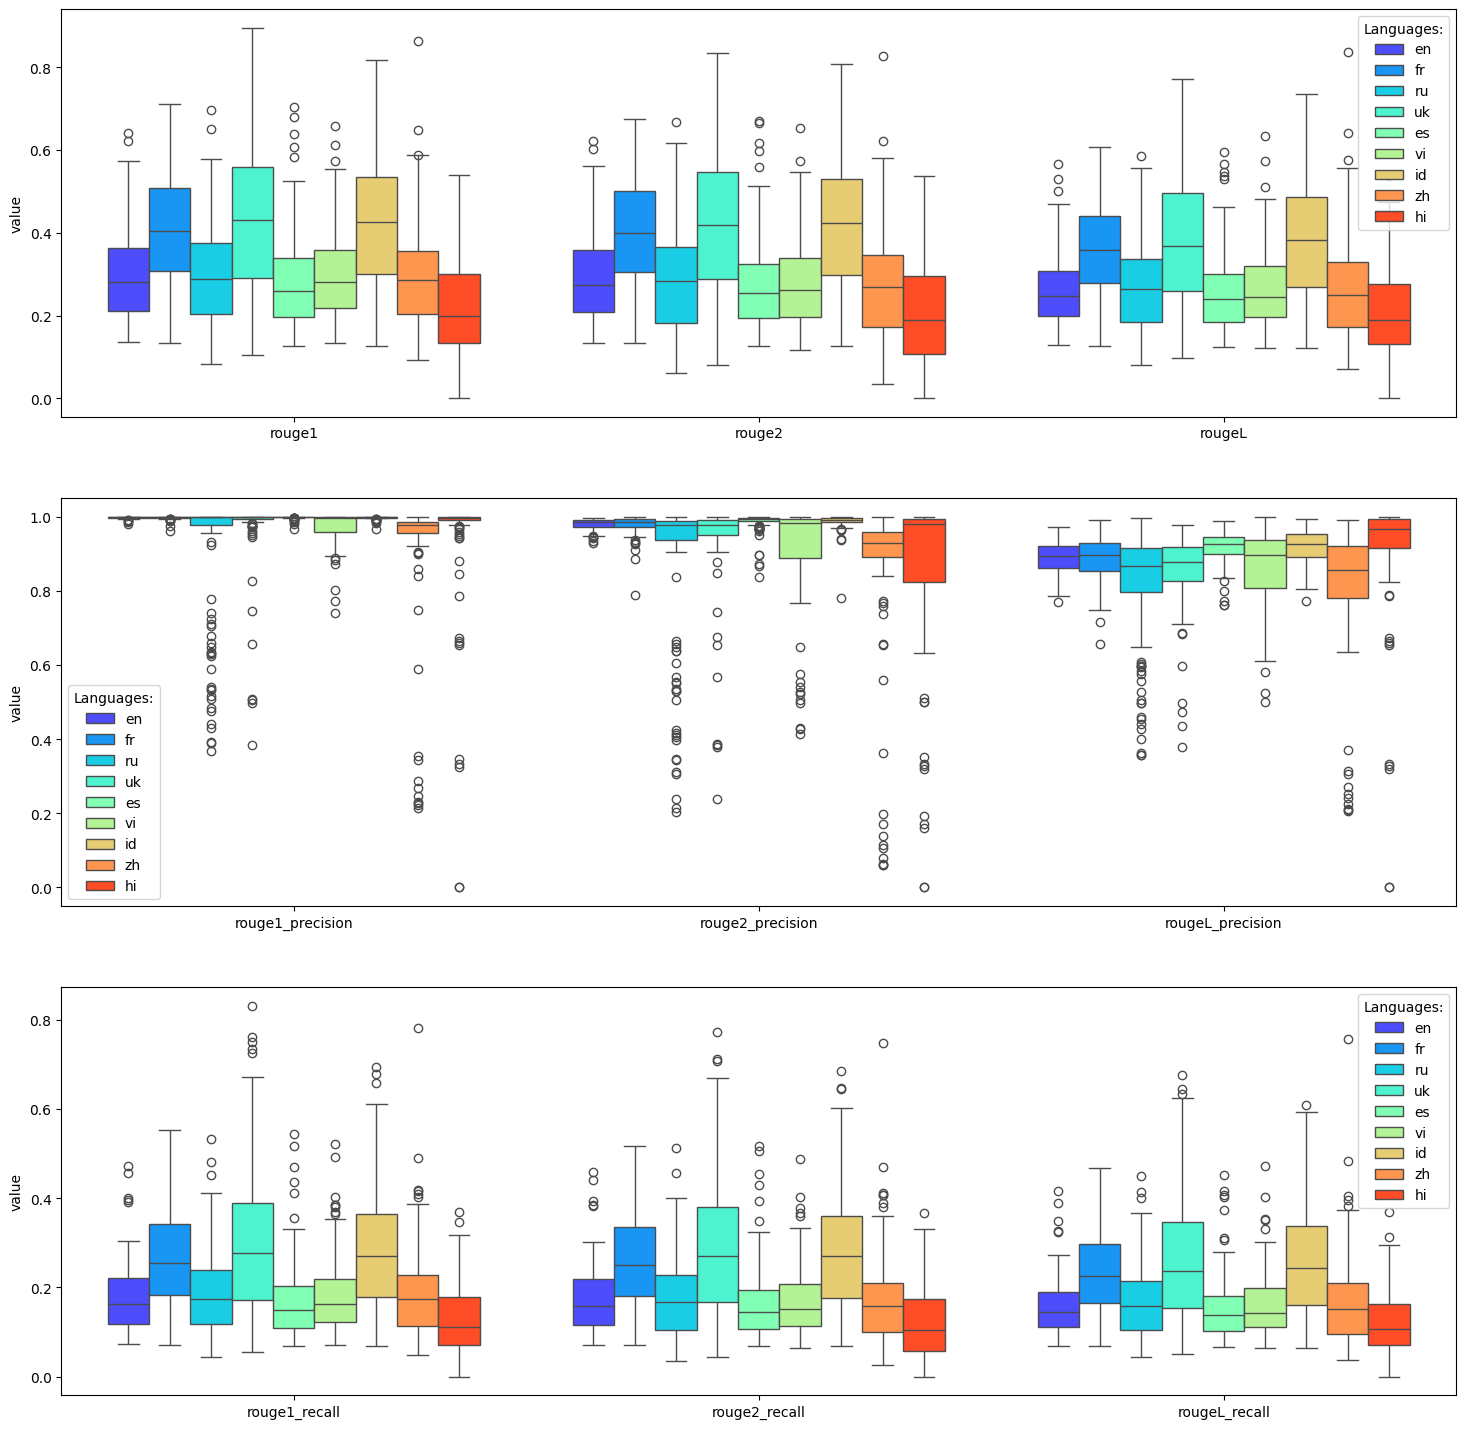

In [6]:
method = "hf"
precision = "16"

fig, axs = plt.subplots(3, 1, figsize=(18, 18), dpi=100)
sns.boxplot(x="", y="value", hue="Languages:", palette="rainbow", saturation=1, ax=axs[0],
            data=prep_data_per_lang(['rouge1', 'rouge2', 'rougeL'], method, precision))
sns.boxplot(x="", y="value", hue="Languages:", palette="rainbow", saturation=1, ax=axs[1],
             data=prep_data_per_lang(['rouge1_precision', 'rouge2_precision', 'rougeL_precision'], method, precision))
sns.boxplot(x="", y="value", hue="Languages:", palette="rainbow", saturation=1, ax=axs[2],
             data=prep_data_per_lang(['rouge1_recall', 'rouge2_recall', 'rougeL_recall'], method, precision))

<Axes: ylabel='value'>

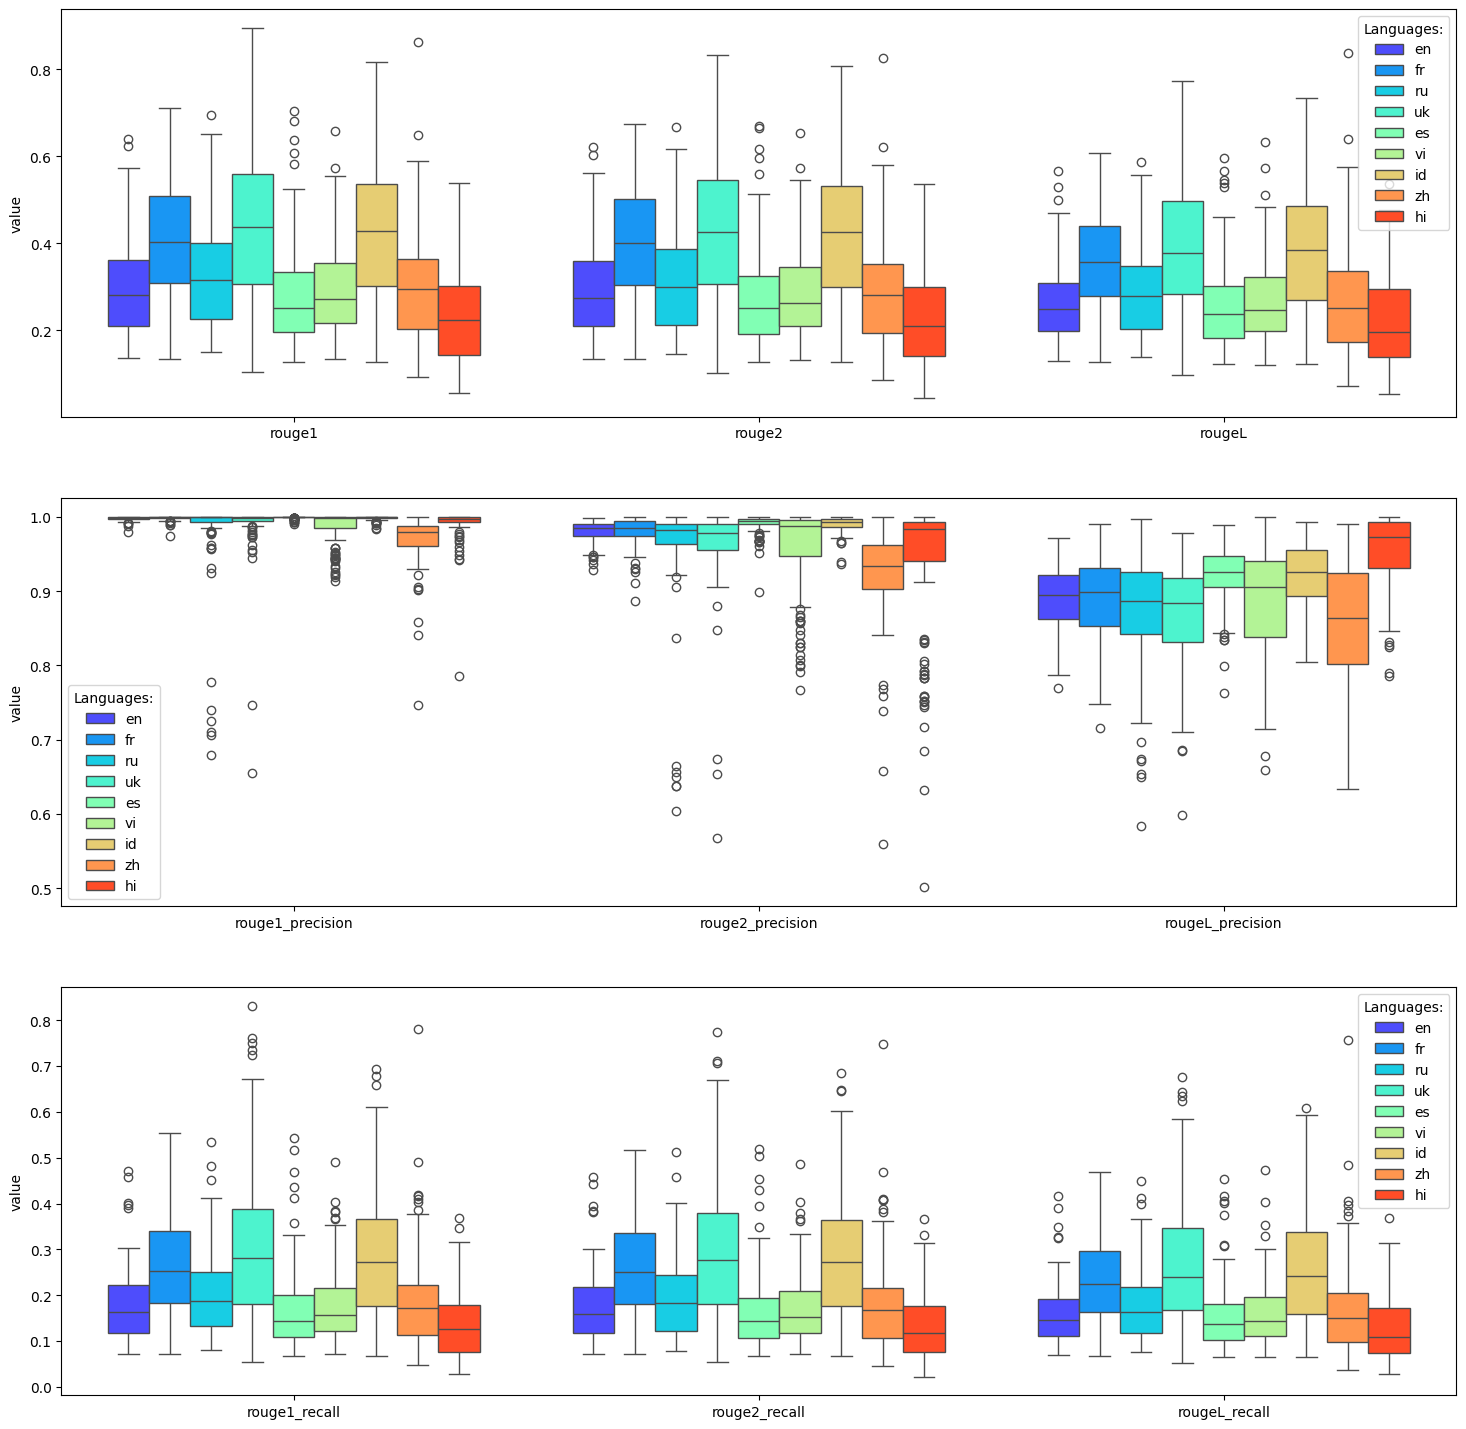

In [7]:
langs = [
    ("en", Language.ENGLISH),
    ("fr", Language.FRENCH),
    ("ru", Language.RUSSIAN),
    ("uk", Language.UKRAINIAN), 
    ("es", Language.SPANISH), 
    ("vi", Language.VIETNAMESE), 
    ("id", Language.INDONESIAN),
    ("zh", Language.CHINESE),
    ("hi", Language.HINDI),

]

languages = [Language.ENGLISH, 
             Language.FRENCH, 
             Language.SPANISH, 
             Language.UKRAINIAN, 
             Language.RUSSIAN, 
             Language.VIETNAMESE, 
             Language.INDONESIAN, 
             Language.CHINESE, 
             Language.HINDI]

detector = LanguageDetectorBuilder.from_languages(*languages).build()

def get_filter(l_code):
    def lang_filter(row):
        return detector.detect_language_of(str(row["response"])) == l_code
    return lang_filter

method = "hf"
precision = "16"

fig, axs = plt.subplots(3, 1, figsize=(18, 18), dpi=100)
sns.boxplot(x="", y="value", hue="Languages:", palette="rainbow", saturation=1, ax=axs[0],
            data=prep_data_per_lang(['rouge1', 'rouge2', 'rougeL'], method, precision, filter_out=True))
sns.boxplot(x="", y="value", hue="Languages:", palette="rainbow", saturation=1, ax=axs[1],
             data=prep_data_per_lang(['rouge1_precision', 'rouge2_precision', 'rougeL_precision'], method, precision, filter_out=True))
sns.boxplot(x="", y="value", hue="Languages:", palette="rainbow", saturation=1, ax=axs[2],
             data=prep_data_per_lang(['rouge1_recall', 'rouge2_recall', 'rougeL_recall'], method, precision, filter_out=True))

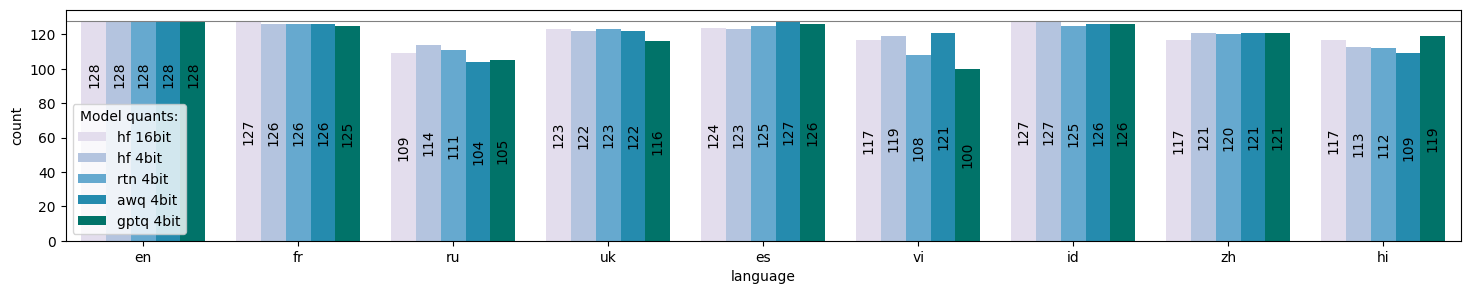

In [8]:
lang_col_name = "language"
quant_col_name = "Model quants:"
target_metric = "count"

bigmerge = None
for method, precision in quants:
    merge = None
    for lang, l_code in langs:
        data = pd.read_csv(f"{src}/{lang}/{method}_{precision}.csv", index_col=0)
        # data = data[data.apply(get_filter(l_code), axis=1)]
        data[target_metric] = data.apply(get_filter(l_code), axis=1).sum()
        data[lang_col_name] = lang
        if merge is None:
            merge = data
        else:
            merge = pd.concat([merge, data])
    merge[quant_col_name] = f"{method} {precision}bit"
    if bigmerge is None:
        bigmerge = merge
    else:
        bigmerge = pd.concat([bigmerge, merge])
        
# melted = pd.melt(merge, id_vars=["Languages:"], value_vars=['rouge1', 'rouge2', 'rougeL'], var_name='')
# melted = pd.melt(merge, id_vars=["Languages:"], value_vars=['rouge1', 'rouge2', 'rougeL', 'rouge1_recall', 'rouge2_recall', 'rougeL_recall'], var_name='')

plt.figure(figsize=(18, 3), dpi=100)
plt.axhline(y=128, color='gray', linestyle='-', linewidth=0.8)
ax = sns.barplot(x=lang_col_name, y=target_metric, hue=quant_col_name, palette="PuBuGn", data=bigmerge, saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="black", padding=0)
    for label in labels:
        label.set_rotation(90)
    for label in labels[:1]:
        label.set_position([label.xy[0], label.xy[1] + 40])

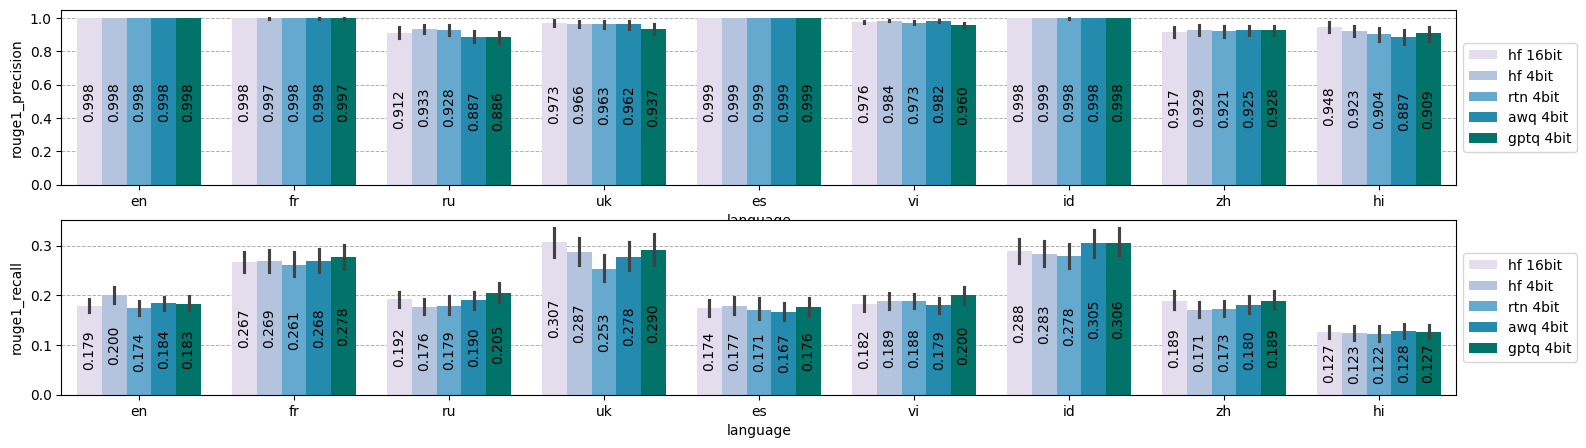

In [9]:
lang_col_name = "language"
quant_col_name = "Model quants:"
target_metrics = ['rouge1_precision', 'rouge1_recall']

fig, axs = plt.subplots(2, 1, figsize=(18, 5), dpi=100)
for n in range(2):
    ax = sns.barplot(x=lang_col_name, y=target_metrics[n], hue=quant_col_name, palette="PuBuGn", saturation=1, ax=axs[n],
                data=prep_data_per_quant(lang_col_name, quant_col_name))
    for container in ax.containers:
        labels = ax.bar_label(container, label_type="center", color="black", padding=0, fmt='%.3f')
        for i, label in enumerate(labels):
            label.set_rotation(90)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
    ax.set_axisbelow(True)

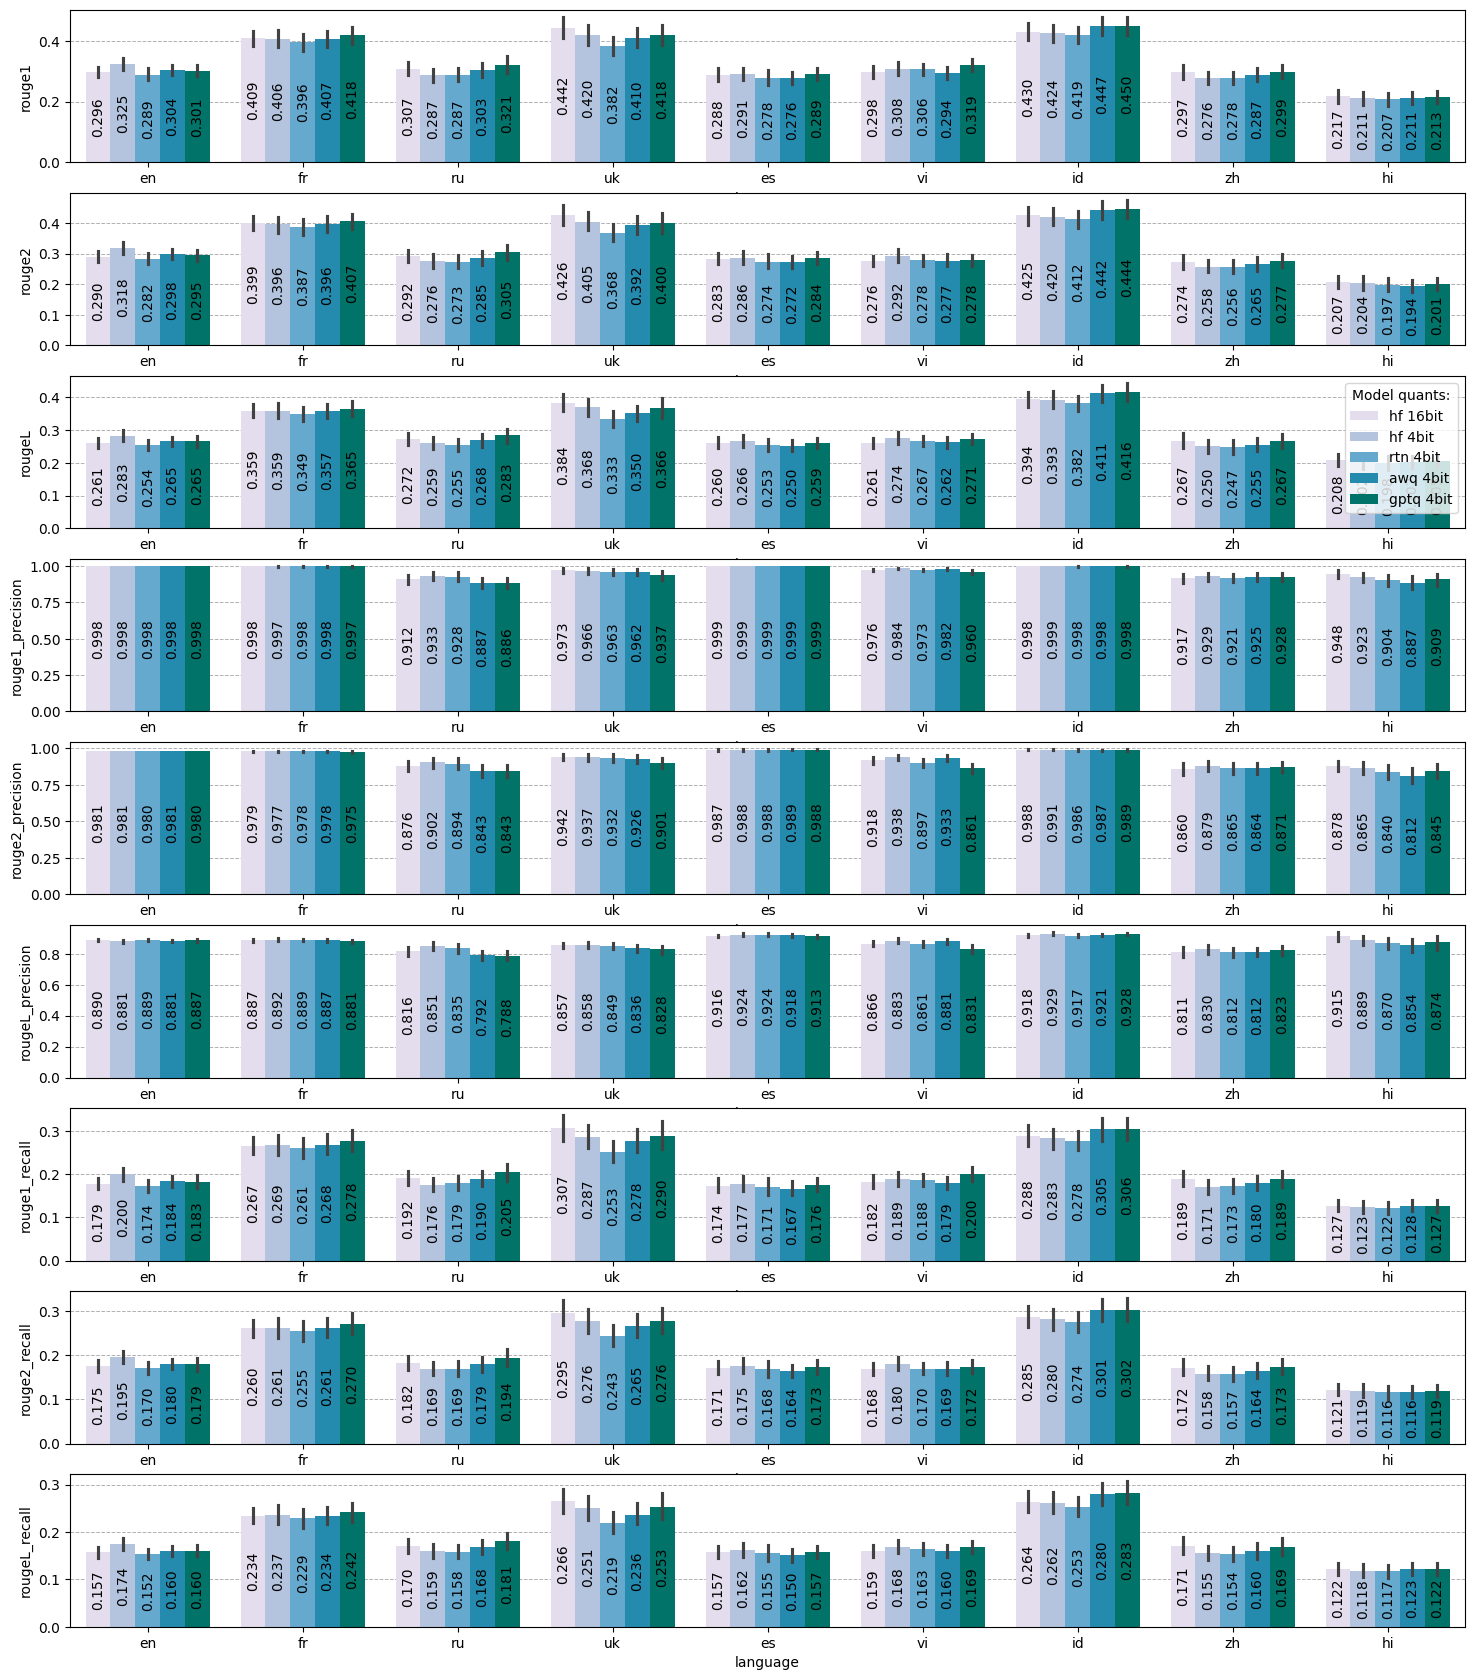

In [10]:
lang_col_name = "language"
quant_col_name = "Model quants:"
target_metrics = [
    "rouge1",
    "rouge2",
    "rougeL",
    "rouge1_precision",
    "rouge2_precision",
    "rougeL_precision",
    "rouge1_recall",
    "rouge2_recall",
    "rougeL_recall",
]

fig, axs = plt.subplots(9, 1, figsize=(18, 21), dpi=100)
data=prep_data_per_quant(lang_col_name, quant_col_name)
for n in range(9):
    ax = sns.barplot(x=lang_col_name, y=target_metrics[n], hue=quant_col_name, palette="PuBuGn", saturation=1, ax=axs[n],
                data=data)

    for container in ax.containers:
        labels = ax.bar_label(container, label_type="center", color="black", padding=0, fmt='%.3f')
        for i, label in enumerate(labels):
            label.set_rotation(90)
            # if i == 7 or (i == 8 and n > 5):
            #     label.set_position([label.xyann[0], label.xyann[1] + 40])
            #     label.set_color("black")
    if n != 2:
        ax.get_legend().remove()
    ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
    ax.set_axisbelow(True)

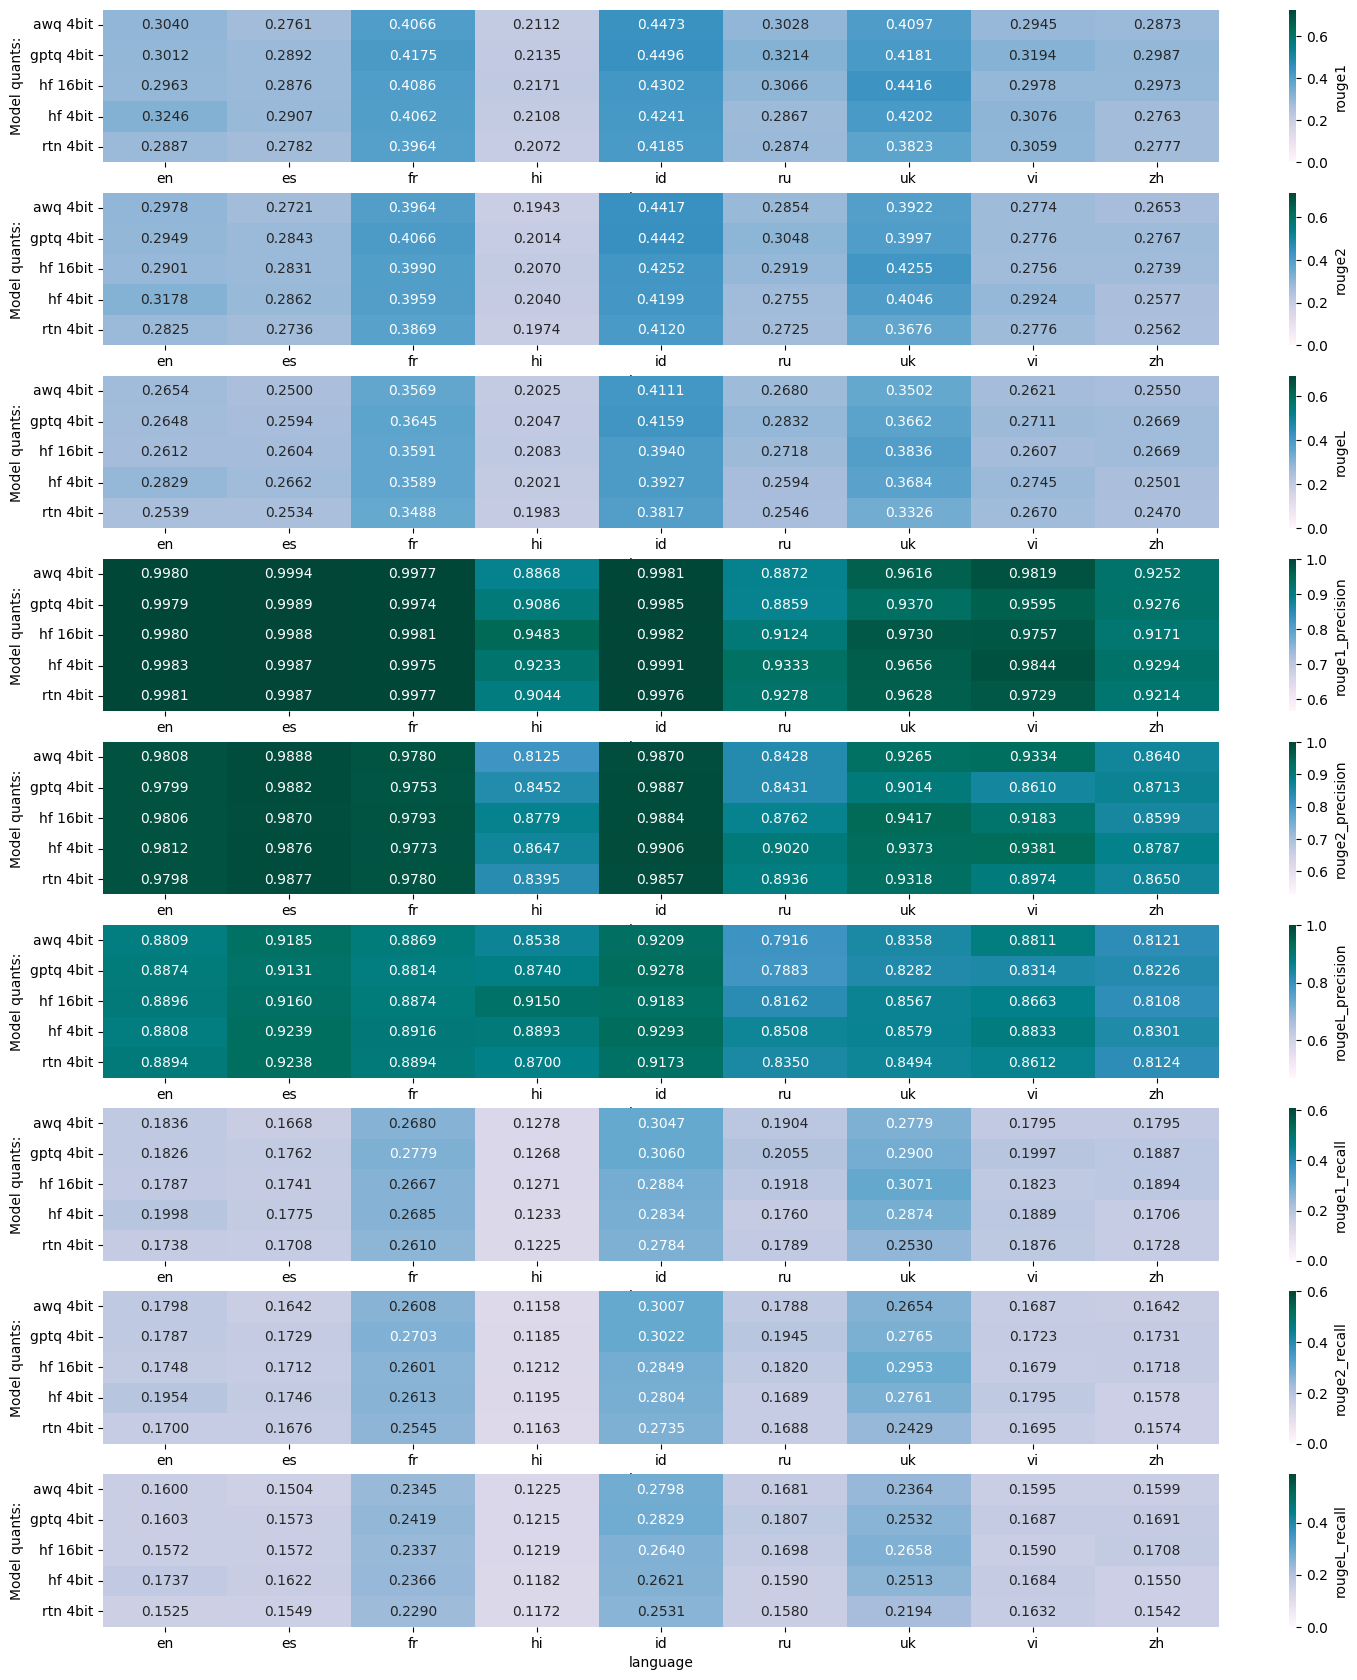

In [11]:
lang_col_name = "language"
quant_col_name = "Model quants:"
target_metrics = [
    "rouge1",
    "rouge2",
    "rougeL",
    "rouge1_precision",
    "rouge2_precision",
    "rougeL_precision",
    "rouge1_recall",
    "rouge2_recall",
    "rougeL_recall",
]

fig, axs = plt.subplots(9, 1, figsize=(18, 21), dpi=100)
data=prep_data_per_quant(lang_col_name, quant_col_name)
for n in range(9):
    offset = 0.4
    vmin = max(0, data.loc[:, target_metrics[n]].mean()-offset)
    vmax = min(1, data.loc[:, target_metrics[n]].mean()+offset)

    ax = sns.heatmap(cmap="PuBuGn", ax=axs[n], vmin=vmin, vmax=vmax, annot=True, fmt=".4f",
            data=data[[lang_col_name, quant_col_name, target_metrics[n]]].pivot_table(index=quant_col_name, columns=lang_col_name, values=target_metrics[n]))
    ax.collections[0].colorbar.set_label(target_metrics[n])

    ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
    ax.set_axisbelow(True)

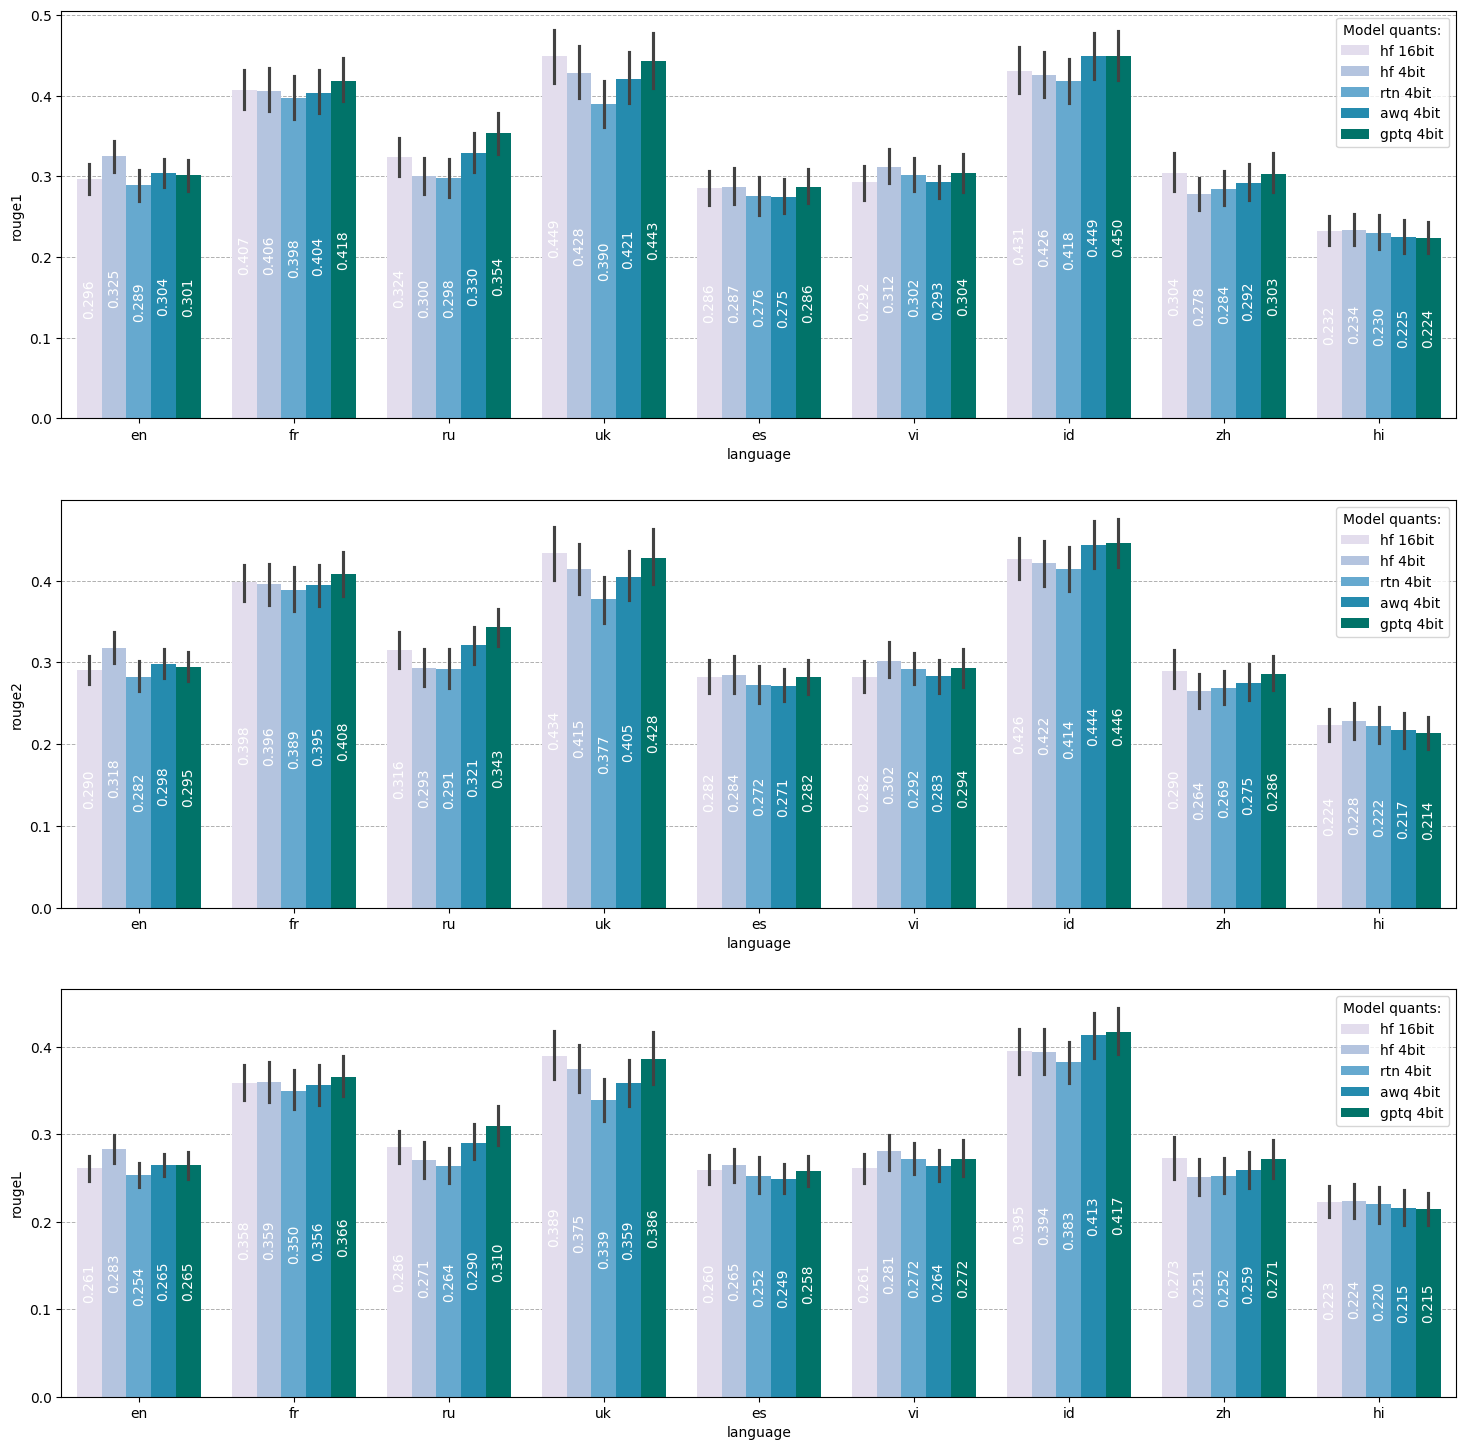

In [12]:
lang_col_name = "language"
quant_col_name = "Model quants:"
target_metrics = ['rouge1', 'rouge2', 'rougeL']

fig, axs = plt.subplots(3, 1, figsize=(18, 18), dpi=100)
for n in range(3):
    ax = sns.barplot(x=lang_col_name, y=target_metrics[n], hue=quant_col_name, palette="PuBuGn", saturation=1, ax=axs[n],
                data=prep_data_per_quant(lang_col_name, quant_col_name, filter_out=True))
    for container in ax.containers:
        labels = ax.bar_label(container, label_type="center", color="white", padding=0, fmt='%.3f')
        for n, label in enumerate(labels):
            label.set_rotation(90)
    
    ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
    ax.set_axisbelow(True)